<a href="https://colab.research.google.com/github/NicholasLeotta99/Neuromatch_BrainCancer/blob/Nick/code/VGG19_Classifier_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
# @title Package Imports
import torch
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision.utils import make_grid
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, TensorDataset
import torchvision.models as models
from torchsummary import summary

import os
from google.colab import files
from PIL import Image

In [7]:
# @title Data Loading
print('Upload kaggle.json account information to download the dataset:')
files.upload()
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset
!unzip -q brain-tumor-mri-dataset.zip

Upload kaggle.json account information to download the dataset:


Saving kaggle.json to kaggle.json
 99% 147M/149M [00:05<00:00, 32.7MB/s]
100% 149M/149M [00:05<00:00, 27.5MB/s]
--2023-07-18 14:36:59--  https://zenodo.org/record/7047164/files/adnoma.zip?download=1
Resolving zenodo.org (zenodo.org)... 188.185.124.72
Connecting to zenodo.org (zenodo.org)|188.185.124.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 88743609 (85M) [application/octet-stream]
Saving to: ‘adnoma.zip?download=1’

adnoma.zip?download 100%[===================>]  84.63M  1.60MB/s    in 1m 45s  

2023-07-18 14:38:46 (824 KB/s) - ‘adnoma.zip?download=1’ saved [88743609/88743609]



In [16]:
#!wget https://zenodo.org/record/7047164/files/adnoma.zip
#!wget https://zenodo.org/record/7047164/files/Gliomas.zip
#!wget https://zenodo.org/record/7047164/files/Meningioma.zip
#!unzip -q ./Gliomas.zip
def grab_format_zenodo(subset, size=(256,256))
!wget
files = os.listdir('./Gliomas')
size=(256,256)
for i in files:
  im = Image.open(f'./Gliomas/{i}')
  i, _ = i.split('.')
  new = im.resize(size)
  if not os.path.isdir('./Glioma_png'):
    os.mkdir('./Glioma_png')
  new.save(f'./Glioma_png/{i}.png', 'png')

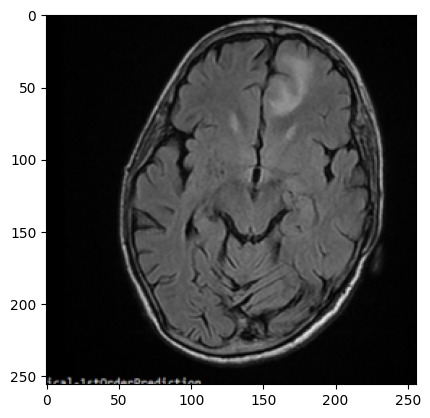

In [ ]:
# @title Loading Model
Classifier = models.vgg19(weights='DEFAULT')
#Replace the classifying linear network with one with custom number of output classes
num_features = Classifier.classifier[-1].in_features
Classifier.classifier[-1] = nn.Linear(num_features, 4)
summary(Classifier, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
              ReLU-2         [-1, 64, 256, 256]               0
            Conv2d-3         [-1, 64, 256, 256]          36,928
              ReLU-4         [-1, 64, 256, 256]               0
         MaxPool2d-5         [-1, 64, 128, 128]               0
            Conv2d-6        [-1, 128, 128, 128]          73,856
              ReLU-7        [-1, 128, 128, 128]               0
            Conv2d-8        [-1, 128, 128, 128]         147,584
              ReLU-9        [-1, 128, 128, 128]               0
        MaxPool2d-10          [-1, 128, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]         295,168
             ReLU-12          [-1, 256, 64, 64]               0
           Conv2d-13          [-1, 256, 64, 64]         590,080
             ReLU-14          [-1, 256,

In [ ]:
classes = os.listdir('./Training/')

0 tensor([3, 1, 3, 1, 2, 1, 3, 0, 3, 0])


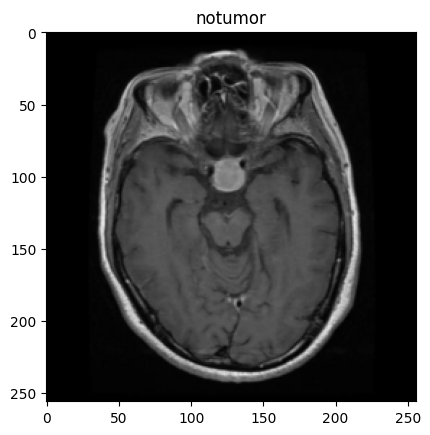

In [ ]:
# @title Dataset Generation
#TODO - Verify labels correspond to classes
data_transf = transforms.Compose([
transforms.Resize((256, 256)),
transforms.ToTensor()])
import matplotlib.pyplot as plt
TrainingDataset = ImageFolder(root='./Training/', transform=data_transf)#, transform=torchvision.models.VGG19_Weights.IMAGENET1K_V1.transforms)
TrainingLoader = DataLoader(TrainingDataset, batch_size=10, shuffle=True)
for batch_number , (images, labels) in enumerate(TrainingLoader):
  print(batch_number, labels)
  plt.imshow(torch.moveaxis(images[0], 0, -1))
  plt.title(classes[labels[0]])
  plt.show()
  break